# Postprocessing

Testing postprocessing (dialation and erosion) to see whether it would improve the predictions.

## Google Colab

The following two cells will be necessary in Google Colab. To avoid problems with imports, they are included in the notebook.

In [ ]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
import os
import glob

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str: 
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive = True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('hyperopt.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

## Imports

In [1]:
import os
import cv2
import torch
import albumentations as A
import numpy as np
import itertools
import segmentation_models_pytorch as smp

from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model, setup_seed
from torch.utils.data import DataLoader
from scripts.preprocessing import get_patched_classification
from scripts.evaluation import get_prediction, get_patched_f1, get_correct_mask
from scripts.plotting import plot_images
from skimage import morphology

## Data

In [3]:
# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

image_path_train, image_path_test, mask_path_train, mask_path_test = split_data(train_directory, 0.1)
# get train and val dataset instances
train_dataset = RoadDataset(image_path_train, mask_path_train)
test_dataset = RoadDataset(image_path_test, mask_path_test)

## Hyperparameters

Since our aim is to see, how different transformations influence the training, we fix the model, epochs and batch sizes.

In [4]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

SEED = 16
BATCH_SIZE = 4
N_CPU = os.cpu_count()
N_EPOCHS = 100

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE,
    'num_workers': N_CPU,
    'persistent_workers': True
}

# Albumentations use many separate image augmentation libraries with different sources for randomization. 
# This is the best effort to have reproducible results. 
setup_seed(SEED)

## Transformations

Define transformations we'll use in evaluating the performance of the model.

In [5]:
# Transforms that will always be applied
base_tf = [A.Resize(height=608, width=608, always_apply=True)]

# Optional transforms that we want to test
transforms_dict = {
    "flip": A.Flip(p=0.5),
    "rotate": A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    "brightness": A.RandomBrightnessContrast(p=0.5),
    "shadow": A.RandomShadow(p=0.5,num_shadows_lower=1, num_shadows_upper=4),
    "coarse dropout": A.CoarseDropout(
        max_holes=8, max_height=50, max_width=50, min_holes=None, min_height=25, min_width=25,
    )
}

In [6]:
# initiate the setups for transformations
col_names = transforms_dict.keys()

# Test optional transforms:
# 1. No transform
# 2. All transforms individually
# 3. All possible pairs of transforms
transform_combinations = [()] + list(itertools.combinations(col_names, 1)) + list(itertools.combinations(col_names, 2))
print(transform_combinations)

[(), ('flip',), ('rotate',), ('brightness',), ('shadow',), ('coarse dropout',), ('flip', 'rotate'), ('flip', 'brightness'), ('flip', 'shadow'), ('flip', 'coarse dropout'), ('rotate', 'brightness'), ('rotate', 'shadow'), ('rotate', 'coarse dropout'), ('brightness', 'shadow'), ('brightness', 'coarse dropout'), ('shadow', 'coarse dropout')]


## Cross-Validation

This cross validation on 16 different combinations took around 7h to train on a RTX 3070 with following presets:
```
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
K_FOLD = 3
N_EPOCHS = 100
model = "DeepLabV3Plus"
```



In [7]:

# get the picked tfs as list
tf_selection = base_tf + list(transforms_dict.values())
train_tf = A.Compose(base_tf + tf_selection)
valid_tf = A.Compose(base_tf)


# Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
train_loader = DataLoader(train_dataset.set_tf(train_tf), **LOADER_PARAMS)
valid_loader = DataLoader(test_dataset.set_tf(valid_tf), **LOADER_PARAMS)

# Initialize model
model_ = smp.create_model("DeepLabV3Plus", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_,
    T_max=(len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size,
)

# Train model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model_, (train_loader, valid_loader), criterion_, optimizer_, scheduler_, N_EPOCHS
)


Epoch:   1. Train.      Loss: 0.529 | f1: 0.506: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
Epoch:   1. Validation. Loss: 0.574 | f1: 0.552: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
Epoch:   2. Train.      Loss: 0.350 | f1: 0.675: 100%|██████████| 23/23 [00:05<00:00,  3.90it/s]
Epoch:   2. Validation. Loss: 0.387 | f1: 0.675: 100%|██████████| 3/3 [00:00<00:00, 14.33it/s]
Epoch:   3. Train.      Loss: 0.286 | f1: 0.712: 100%|██████████| 23/23 [00:05<00:00,  3.88it/s]
Epoch:   3. Validation. Loss: 0.385 | f1: 0.633: 100%|██████████| 3/3 [00:00<00:00, 14.15it/s]
Epoch:   4. Train.      Loss: 0.247 | f1: 0.746: 100%|██████████| 23/23 [00:06<00:00,  3.57it/s]
Epoch:   4. Validation. Loss: 0.205 | f1: 0.799: 100%|██████████| 3/3 [00:00<00:00, 13.24it/s]
Epoch:   5. Train.      Loss: 0.226 | f1: 0.755: 100%|██████████| 23/23 [00:06<00:00,  3.30it/s]
Epoch:   5. Validation. Loss: 0.198 | f1: 0.784: 100%|██████████| 3/3 [00:00<00:00, 11.71it/s]
Epoch:   6. Train.      Loss: 0.205 | f1

f1: 0.49
Dilated f1: 0.49


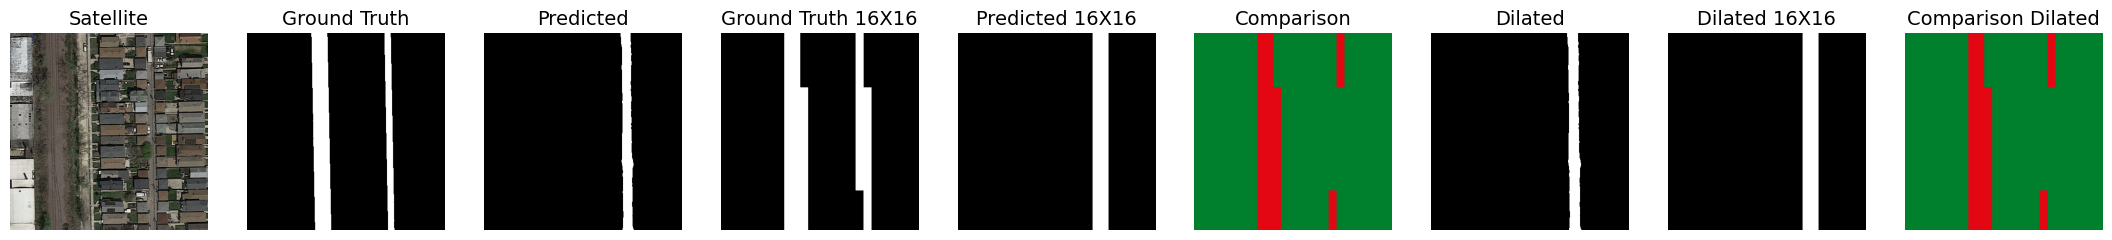

f1: 0.83
Dilated f1: 0.82


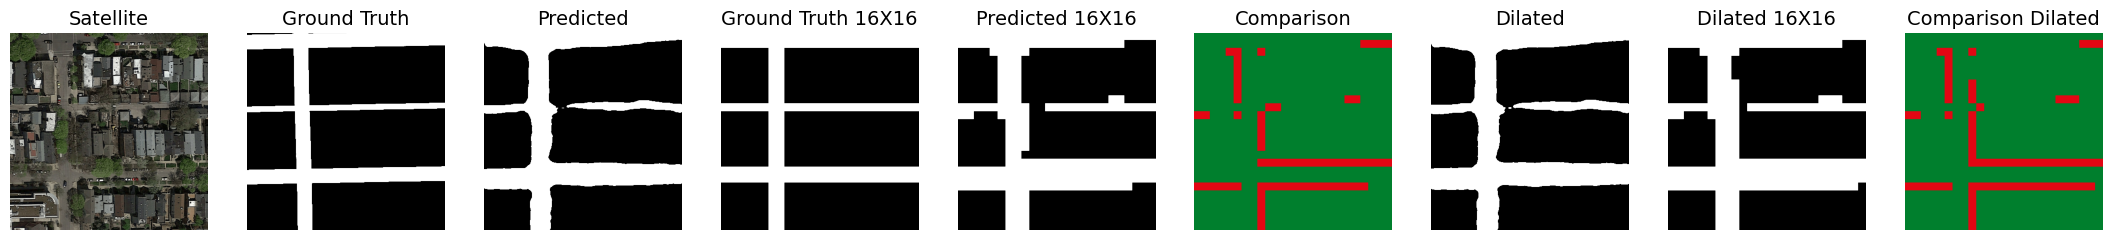

f1: 0.82
Dilated f1: 0.80


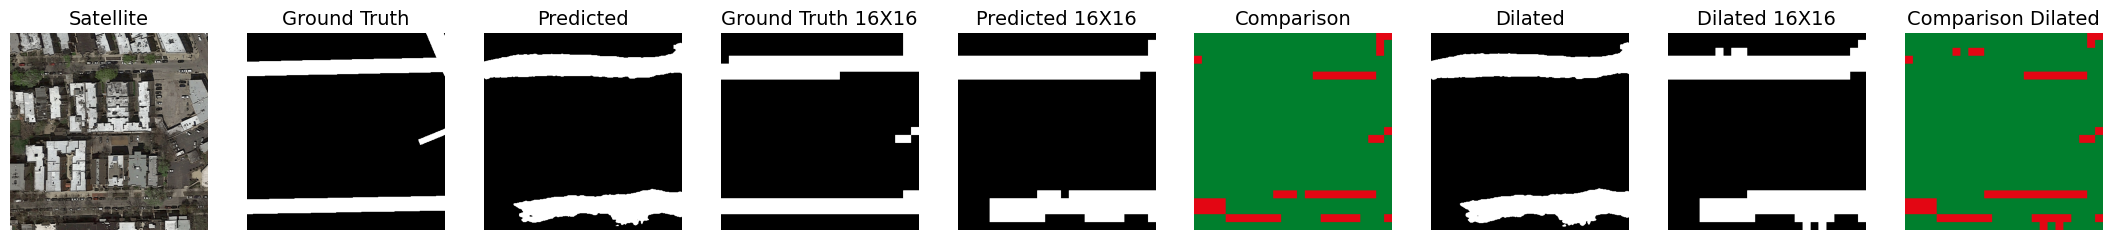

f1: 0.35
Dilated f1: 0.36


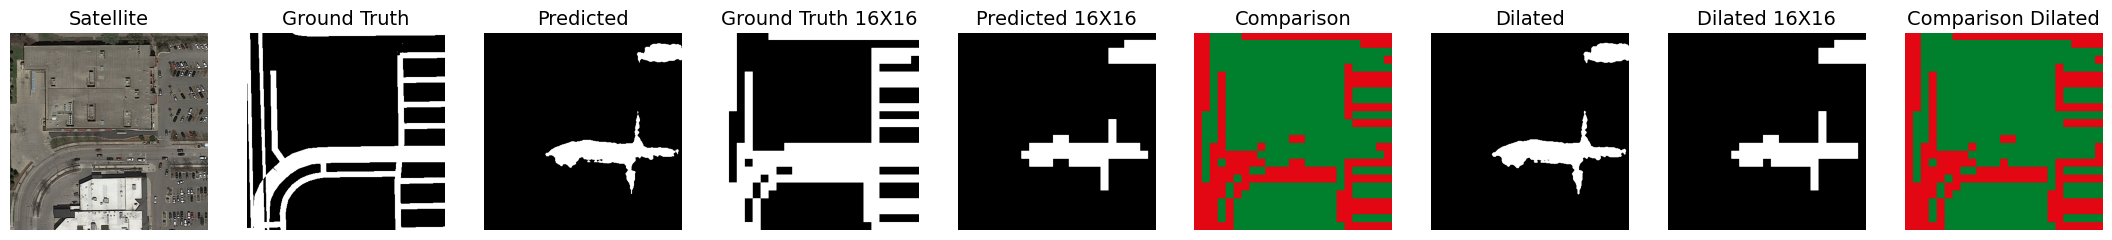

f1: 0.79
Dilated f1: 0.80


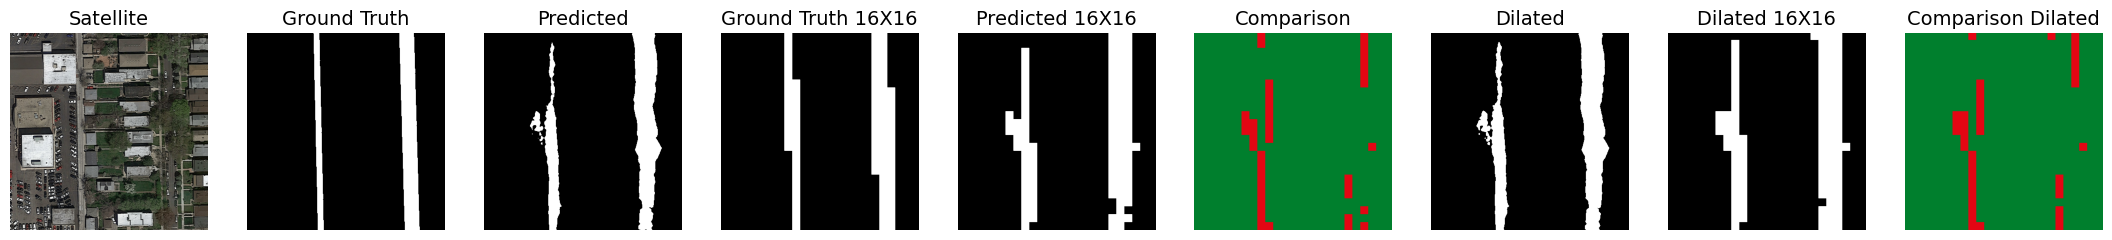

In [8]:
def plot_n_predictions(
        model,
        dataloader,
        num_images: int = 5,
        is_patched: bool = True,
        is_comparison: bool = True,
        is_dialate = True
):
    """
    Plot image with ground truth and prediction. If booleans are true,
        plot patched versions of the mask and predictions alongside
        the comparison of the two.

    :param model: trained
    :param dataloader: with batch_size=1
    :param num_images: to plot
    :param is_patched: if True -> plot patched mask and prediction
    :param is_comparison: if True -> plot patched comparison
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    image_count = 0

    for image, label in dataloader:
        image, label = image.to(device), label.to(device)
        predicted = get_prediction(model, image)
        
        print('f1: {:.2f}'.format(get_patched_f1(predicted, label)))

        extra_plots = {}
        if is_patched:
            extra_plots['ground_truth_16x16'] = get_patched_classification(label)
            extra_plots['predicted_16x16'] = get_patched_classification(predicted)
        if is_comparison:
            extra_plots['comparison'] = get_correct_mask(
                extra_plots['ground_truth_16x16'], extra_plots['predicted_16x16']
            )
        if is_dialate:
            """ Dilate the image once and visualize differences with base prediction."""
            
            dilated = morphology.binary_dilation(predicted).astype(np.uint8)
            # for i in range(1):
            #     dilated = morphology.binary_dilation(dilated).astype(np.uint8)
            
            # Add plots for dialation results
            extra_plots['dilated'] = dilated
            extra_plots['dilated_16x16'] = get_patched_classification(dilated)
            extra_plots['comparison_dilated'] = get_correct_mask(
                extra_plots['ground_truth_16x16'], extra_plots['dilated_16x16']
            )
            
            print('Dilated f1: {:.2f}'.format(get_patched_f1(dilated, label)))
            
            

        plot_images(
            axis=False,
            satellite=image,
            ground_truth=label,
            predicted=predicted,
            **extra_plots
        )

        image_count += 1
        if image_count >= num_images:
            break



test_loader = DataLoader(test_dataset, batch_size=1)
plot_n_predictions(model_, test_loader, num_images=5)

In [9]:
from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dilation_results = defaultdict(lambda: np.array([]))

for image, label in test_loader:
    image, label = image.to(device), label.to(device)
    predicted = get_prediction(model_, image)
    
    dilation_results[0] = np.append(dilation_results[0], get_patched_f1(predicted, label))
    
    dilated = predicted.copy()
    # Apply dilation 
    for i in range(1,6):
        dilated = morphology.binary_dilation(dilated).astype(np.uint8)
        dilation_results[i] = np.append(dilation_results[i], get_patched_f1(dilated, label))
    
for key, results in dilation_results.items():
    print(f'Dialation count={key}, f1: {results.mean():.2f}')


Dialation count=0, f1: 0.76
Dialation count=1, f1: 0.75
Dialation count=2, f1: 0.74
Dialation count=3, f1: 0.74
Dialation count=4, f1: 0.73
Dialation count=5, f1: 0.72


In [10]:
erosion_results = defaultdict(lambda: np.array([]))

for image, label in test_loader:
    image, label = image.to(device), label.to(device)
    predicted = get_prediction(model_, image)
    
    erosion_results[0] = np.append(erosion_results[0], get_patched_f1(predicted, label))
    
    eroded = predicted.copy()
    for i in range(1,6):
        eroded = morphology.binary_erosion(eroded).astype(np.uint8)
        erosion_results[i] = np.append(erosion_results[i], get_patched_f1(eroded, label))
    
for key, results in erosion_results.items():
    print(f'Erosion count={key}, f1: {results.mean():.2f}')

Erosion count=0, f1: 0.76
Erosion count=1, f1: 0.76
Erosion count=2, f1: 0.76
Erosion count=3, f1: 0.76
Erosion count=4, f1: 0.75
Erosion count=5, f1: 0.72
